# Imports

In [1]:
import os
import pandas
from bumps.cli import load_model, load_best
from bumps.dream.state import load_state
from scattertools.support import molstat
import shutil

from IPython.core.magic import register_cell_magic
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# Variables

Variables to set the storage folder for the fit, the base name of the runfile, and the global optimizer. Further the
number of burn and production stepst for the MCMC are set. The run flag determines whether the refl1d MCMC is run, or
just a data analysis on a previous fit is performed.

Steps (and burn) are intentionally small in this example to reduce file sizes.

In [2]:
setupdir = os.getcwd()
store = "MCMC_64000_500"
runfile = "run"
fitsource = "refl1d"

if not os.path.isdir(store):
    os.mkdir(store)

run = True
burn = 20
steps = 20


# Fit

The content of the following cell is written out to the runfile of the fit 'tblm.py'.

In [3]:
%%write_and_run run.py
# === Import section ===
import numpy
from molgroups import mol
from molgroups import components as cmp
from molgroups import lipids
from refl1d.names import load4, Parameter, SLD, Slab, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

# === Constant definition section ===
# Canvas
DIMENSION = 700
STEPSIZE = 0.5

# Hermite Spline
CONTROLPOINTS = 6
SPACING = 15.0
PENETRATION = 12
dDp = [None] * CONTROLPOINTS
dVf = [None] * CONTROLPOINTS

# SLDS
PROTDEUT = 12e-6
PROTNONDEUT = 12e-6
NSLDH2O = 9.41
NSLDD2O = 9.30

XRAY = 1.5406

# Define bilayer and protein objects
blm = mol.ssBLM(lipids=[lipids.POPC, lipids.PAPC, lipids.POPE, lipids.DLPE, lipids.DPSM, lipids.PAPS, lipids.POPIP2, lipids.chol, lipids.DOPE], 
               lipid_nf=[0.113, 0.061, 0.044, 0.131, 0.088, 0.161, 0.022, 0.28, 0.10],
               xray_wavelength=XRAY)

protein = mol.Hermite()
protein.numberofcontrolpoints = CONTROLPOINTS
blm_prot = mol.BLMProteinComplex(blms=[blm], proteins=[protein])

dense_polymer = mol.Box2Err()
sparse_polymer = mol.Box2Err()

# Bilayer profile definition function
def bilayer(z, sigma, bulknsld, global_rough, rho_substrate, rho_siox, l_siox, l_dense_polymer, l_sparse_polymer, vf_dense_polymer, vf_sparse_polymer, rho_polymer, 
            l_lipid1, l_lipid2, vf_bilayer):
    """ Generic tethered bilayer """

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6
    rho_substrate *= 1e-6
    rho_siox *= 1e-6
    rho_polymer *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate, 
              rho_siox=rho_siox, l_siox=l_siox, l_submembrane=l_dense_polymer+l_sparse_polymer,
              l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)
    # Calculate scattering properties of volume occupied by bilayer
    maxarea, area, nsl = blm.fnWriteProfile(z)
    # normarea equals maxarea because of substrate layers, otherwise normarea = blm.normarea
    normarea = maxarea
    
    # add in polymer cushion, protein penetration into cushion is not explicitely treated assuming that the
    # polymer density is always low
    vol_dense_polymer = normarea*l_dense_polymer
    dense_polymer.fnSet(volume=vol_dense_polymer, length=l_dense_polymer, position=blm.siox.z+0.5*blm.siox.length,
                        nSL=rho_polymer*vol_dense_polymer, sigma=sigma, nf=vf_dense_polymer)
    vol_sparse_polymer = normarea*l_sparse_polymer
    sparse_polymer.fnSet(volume=vol_sparse_polymer, length=l_sparse_polymer, position=dense_polymer.z+0.5*dense_polymer.length,
                         nSL=rho_polymer*vol_sparse_polymer, sigma=sigma, nf=vf_sparse_polymer)
    area, nsl = dense_polymer.fnOverlayProfile(z, area, nsl, maxarea)
    area, nsl = sparse_polymer.fnOverlayProfile(z, area, nsl, maxarea)
    
    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * numpy.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    # problem.bilayers = [blm]
    # problem.dimension = DIMENSION
    # problem.stepsize = STEPSIZE
    # problem.moldat = blm.fnWriteGroup2Dict({}, 'bilayer', numpy.arange(DIMENSION) * STEPSIZE)

    # Return nSLD profile in Refl1D units
    return nsld * 1e6


def bilayer_prot(z, sigma, bulknsld, global_rough, rho_substrate, rho_siox, l_siox, l_dense_polymer, l_sparse_polymer, 
                 vf_dense_polymer, vf_sparse_polymer, rho_polymer, l_lipid1, l_lipid2, vf_bilayer, nf_protein, 
                 protexchratio, penetration, dDp, dVf):
    """ Generic tethered bilayer """

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6
    rho_substrate *= 1e-6
    rho_siox *= 1e-6
    rho_polymer *= 1e-6

    # Calculate scattering properties of volume occupied by bilayer
    protSLD = PROTNONDEUT + protexchratio * (bulknsld-NSLDH2O) / (NSLDD2O-NSLDH2O) * (PROTDEUT-PROTNONDEUT)
    blm_prot.proteins[0].fnSetRelative(SPACING, blm.headgroups2[0].fnGetZ() + 0.5 * 9.56 - penetration, dDp, dVf, protSLD, nf_protein)
    blm_prot.blms[0].fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate, rho_siox=rho_siox, l_siox=l_siox, 
                           l_submembrane=l_dense_polymer+l_sparse_polymer, l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)
    blm_prot.fnAdjustBLMs()
    maxarea, area, nsl = blm_prot.fnWriteProfile(z)
    # normarea equals maxarea because of substrate layers, otherwise normarea = blm_prot.blms[0].normarea, for example
    normarea = maxarea
    
    # add in polymer cushion, protein penetration into cushion is not explicitely treated assuming that the
    # polymer density is always low
    vol_dense_polymer = normarea*l_dense_polymer
    dense_polymer.fnSet(volume=vol_dense_polymer, length=l_dense_polymer, position=blm.siox.z+0.5*blm.siox.length,
                        nSL=rho_polymer*vol_dense_polymer, sigma=sigma, nf=vf_dense_polymer)
    vol_sparse_polymer = normarea*l_sparse_polymer
    sparse_polymer.fnSet(volume=vol_sparse_polymer, length=l_sparse_polymer, position=dense_polymer.z+0.5*dense_polymer.length,
                         nSL=rho_polymer*vol_sparse_polymer, sigma=sigma, nf=vf_sparse_polymer)
    area, nsl = dense_polymer.fnOverlayProfile(z, area, nsl, maxarea)
    area, nsl = sparse_polymer.fnOverlayProfile(z, area, nsl, maxarea)    
    
    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * numpy.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be in this function
    # for statistical analysis of molgroups
    moldict1 = blm_prot.blms[0].fnWriteGroup2Dict({}, 'bilayer', numpy.arange(DIMENSION) * STEPSIZE)
    moldict2 = blm_prot.proteins[0].fnWriteGroup2Dict({}, 'protein', numpy.arange(DIMENSION) * STEPSIZE)
    moldict3 = dense_polymer.fnWriteGroup2Dict({}, 'dense_polymer', numpy.arange(DIMENSION) * STEPSIZE)
    moldict4 = sparse_polymer.fnWriteGroup2Dict({}, 'sparse_polymer', numpy.arange(DIMENSION) * STEPSIZE)
    problem.moldat = {**moldict1, **moldict2, **moldict3, **moldict4}
    dict1 = blm_prot.blms[0].fnWriteResults2Dict({}, 'bilayer')
    dict2 = blm_prot.proteins[0].fnWriteResults2Dict({}, 'protein')
    dict3 = dense_polymer.fnWriteResults2Dict({}, 'dense_polymer')
    dict4 = sparse_polymer.fnWriteResults2Dict({}, 'sparse_polymer')
    problem.results = {**dict1, **dict2, **dict3, **dict4}
                        
    # Return nSLD profile in Refl1D units
    return nsld * 1e6

# substrate parameters
global_rough = Parameter(name='sigma_substrate', value=5)              #substrate roughness
d_oxide = Parameter(name='d_oxide', value=10)                          #silicon oxide thickness

# polymer parameters
l_dense_polymer = Parameter(name='l_dense_polymer', value=20).range(10., 100.)
l_sparse_polymer = Parameter(name='l_sparse_polymer', value=50).range(10., 100.)
vf_dense_polymer = Parameter(name='vf_dense_polymer', value=0.4).range(0.02, 0.5)
vf_sparse_polymer = Parameter(name='vf_sparse_polymer', value=0.1).range(0.01, 0.5)

# bilayer parameters
vf_bilayer = Parameter(name='vf_bilayer', value=1.00)                   #volume fraction bilayer
l_lipid1 = Parameter(name='l_lipid1', value=14.0)                       #inner methylenes
l_lipid2 = Parameter(name='l_lipid2', value=14.0)                       #outer methylenes
sigma = Parameter(name='sigma_blm', value=5)                            #bilayer roughness

# protein parameters
protein_penetration = Parameter(name='protein_penetration', value=0).range(-50, 10)
nf_protein = Parameter(name='nf_protein', value=1.).range(0., 1.)
protexchratio = 0.8

for i in range(len(dDp)):
    dDp[i] = Parameter(name='dDp'+str(i), value=0.0)
for i in range(1, len(dVf)-1):
    dVf[i] = Parameter(name='dVf'+str(i), value=0.01).range(0.0, 0.4)
# first and last controlpoint is at zero volume fraction
dVf[0] = dVf[-1] = 0.0

# === Stack ===
# First, we create a 'material' for each bulk layer, which has an real and imaginary
# scattering length density, stored in a Refl1d object called 'SLD'

h2o = SLD(name='h2o', rho=NSLDH2O, irho=0.2)
h2o_prot = SLD(name='h2o_prot', rho=NSLDH2O, irho=0.2)

silicon = SLD(name='silicon', rho=19.67, irho=0.5)
siox = SLD(name='siox', rho=17.73, irho=0.294)
polymer = SLD(name='polymer', rho=11, irho=0.5)

# Then bulk layers are created, each with its own 'material'.  If you want to force
# two layers to always match SLD you can use the same material in multiple layers.
# The roughnesses of each layer are set to zero to begin with:

layer_h2o = Slab(material=h2o, thickness=0.0000, interface=5.0000)
layer_h2o_prot = Slab(material=h2o_prot, thickness=0.0000, interface=5.0000)
layer_siox = Slab(material=siox, thickness=d_oxide, interface=global_rough)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=global_rough)

# Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
# Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(DIMENSION * STEPSIZE, 0, profile=bilayer, sigma=sigma, bulknsld=h2o.rho, global_rough=global_rough, 
                             rho_substrate=silicon.rho, rho_siox=siox.rho, l_siox=d_oxide, l_dense_polymer=l_dense_polymer, 
                             l_sparse_polymer=l_sparse_polymer, vf_dense_polymer=vf_dense_polymer, vf_sparse_polymer=vf_sparse_polymer, 
                             rho_polymer=polymer.rho, l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)
mollayer_prot = FunctionalProfile(DIMENSION * STEPSIZE, 0, profile=bilayer_prot, sigma=sigma, bulknsld=h2o_prot.rho, global_rough=global_rough, 
                                  rho_substrate=silicon.rho, rho_siox=siox.rho, l_siox=d_oxide, l_dense_polymer=l_dense_polymer, 
                                  l_sparse_polymer=l_sparse_polymer, vf_dense_polymer=vf_dense_polymer, vf_sparse_polymer=vf_sparse_polymer, 
                                  rho_polymer=polymer.rho, l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer, nf_protein=nf_protein, 
                                  protexchratio=protexchratio, penetration=protein_penetration, dDp=dDp, dVf=dVf)

# Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
# Always build the sample from the substrate up. If the neutron beam is incident from the substrate side,
# set back_reflectivity = True in the probe definition later.

sample = layer_silicon | mollayer | layer_h2o
sample_prot = layer_silicon | mollayer_prot | layer_h2o_prot

# Set sample parameter ranges and constraints between layer properties, if these are not set using parameters previously

# nSLD parameters
# h2o.rho.range(-0.6, 0.6)
# h2o_prot.rho.range(-0.6, 0.6)
# siox.rho.range(2.7000, 3.80)

# === Data files ===
probe = load4('IvsQ_76529+76544_76530_76531.dat', back_reflectivity=True)
probe_prot = load4('IvsQ_76548_76549_76550.dat', back_reflectivity=True)

# Background parameter
# probe.background.value = 0.0000
probe.background.range(-1e-9, 1e-5)
probe_prot.background.range(-1e-9, 1e-5)

# Define critical edge oversampling for samples that require it (typically D2O only)
# probe.critical_edge(substrate=silicon, surface=d2o)

# === Problem definition ===
# a model object consists of a sample and a probe,

# step = True corresponds to a calculation of the reflectivity from an actual profile
# with microslabbed interfaces.  When step = False, the Nevot-Croce
# approximation is used to account for roughness.  This approximation speeds up
# the calculation tremendously, and is reasonably accuarate as long as the
# roughness is much less than the layer thickness
step = False

model = Experiment(sample=sample, probe=probe, dz=STEPSIZE, step_interfaces=step)
model_prot = Experiment(sample=sample_prot, probe=probe_prot, dz=STEPSIZE, step_interfaces=step)
problem = FitProblem([model, model_prot])

# Running the fit

The following runs the fit using rs.py. It can also be run manually from the command line using, for example:
> refl1d_cli.py tblm.py --fit=dream --init=lhs --parallel --store=fit --burn=16000 --steps=500

No file: /Users/frank/Documents/programming/molgroups/examples/data_fitting/refl1d/xray_polymer_cushioned_bilayer/MCMC_64000_500/run.py
No state to reload.
# steps: 20, # draws: 2400
step 1 cost 714.858(81)
 background IvsQ_76529+76544_76530_76531 ....|..... 4.35435e-06 in (-1e-09, 1e-05)
                         l_dense_polymer ........|.    85.3172 in (10.0, 100.0)
                        l_sparse_polymer ........|.    85.8084 in (10.0, 100.0)
                        vf_dense_polymer .........|   0.497746 in (0.02, 0.5)
                       vf_sparse_polymer ..|.......   0.150693 in (0.01, 0.5)
       background IvsQ_76548_76549_76550 ..|....... 2.6663e-06 in (-1e-09, 1e-05)
                                    dVf1 ......|...   0.248515 in (0.0, 0.4)
                                    dVf2 .........|   0.374962 in (0.0, 0.4)
                                    dVf3 ......|...   0.252739 in (0.0, 0.4)
                                    dVf4 |.........  0.0250238 in (0.0, 0.4)
    

Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/refl1d/experiment.py", line 238, in save_json
    experiment = serialize(self)
                 ^^^^^^^^^^^^^^^
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/serialize.py", line 190, in serialize
    "object": obj_to_dict(obj),
              ^^^^^^^^^^^^^^^^
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/serialize.py", line 168, in obj_to_dict
    return dataclass_to_dict(obj)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/serialize.py", line 151, in dataclass_to_dict
    output = dict([(f.name, obj_to_dict(getattr(dclass, f.name))) for f in all_fields])
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/serialize.py", line

-- Model 0 IvsQ_76529+76544_76530_76531
.probe
  .back_absorption = back_absorption IvsQ_76529+76544_76530_76531 = 1
  .background = background IvsQ_76529+76544_76530_76531 = 1.23517e-06 in [0,1e-05]
  .intensity = intensity IvsQ_76529+76544_76530_76531 = 1
  .sample_broadening = sample_broadening IvsQ_76529+76544_76530_76531 = 0
  .theta_offset = theta_offset IvsQ_76529+76544_76530_76531 = 0
.sample
  .layers
    [0]
      .interface = sigma_substrate = 5
      .material
        .irho = silicon irho = 0.5
        .rho = silicon rho = 19.67
      .thickness = silicon thickness = 0
    [1]
      .bulknsld = h2o rho = 9.41
      .global_rough = sigma_substrate = 5
      .interface = bilayer interface = 0
      .l_dense_polymer = 81.9591 in [10,100]
      .l_lipid1 = 14
      .l_lipid2 = 14
      .l_siox = d_oxide = 10
      .l_sparse_polymer = 76.5608 in [10,100]
      .rho_polymer = polymer rho = 11
      .rho_siox = siox rho = 17.73
      .rho_substrate = silicon rho = 19.67
      .sig

Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/refl1d/experiment.py", line 238, in save_json
    experiment = serialize(self)
                 ^^^^^^^^^^^^^^^
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/serialize.py", line 190, in serialize
    "object": obj_to_dict(obj),
              ^^^^^^^^^^^^^^^^
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/serialize.py", line 168, in obj_to_dict
    return dataclass_to_dict(obj)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/serialize.py", line 151, in dataclass_to_dict
    output = dict([(f.name, obj_to_dict(getattr(dclass, f.name))) for f in all_fields])
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/frank/opt/anaconda3/envs/refl1d/lib/python3.11/site-packages/bumps/serialize.py", line

-- Model 0 IvsQ_76529+76544_76530_76531
.probe
  .back_absorption = back_absorption IvsQ_76529+76544_76530_76531 = 1
  .background = background IvsQ_76529+76544_76530_76531 = 1.23517e-06 in [0,1e-05]
  .intensity = intensity IvsQ_76529+76544_76530_76531 = 1
  .sample_broadening = sample_broadening IvsQ_76529+76544_76530_76531 = 0
  .theta_offset = theta_offset IvsQ_76529+76544_76530_76531 = 0
.sample
  .layers
    [0]
      .interface = sigma_substrate = 5
      .material
        .irho = silicon irho = 0.5
        .rho = silicon rho = 19.67
      .thickness = silicon thickness = 0
    [1]
      .bulknsld = h2o rho = 9.41
      .global_rough = sigma_substrate = 5
      .interface = bilayer interface = 0
      .l_dense_polymer = 81.9591 in [10,100]
      .l_lipid1 = 14
      .l_lipid2 = 14
      .l_siox = d_oxide = 10
      .l_sparse_polymer = 76.5608 in [10,100]
      .rho_polymer = polymer rho = 11
      .rho_siox = siox rho = 17.73
      .rho_substrate = silicon rho = 19.67
      .sig

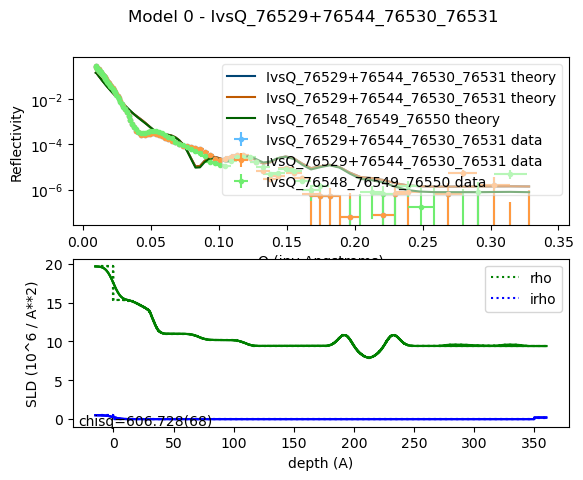

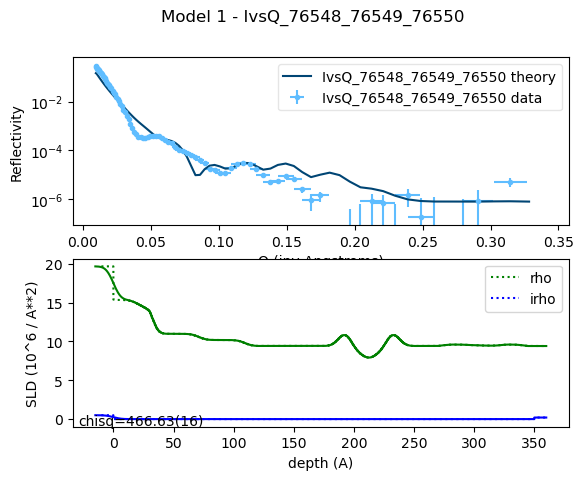

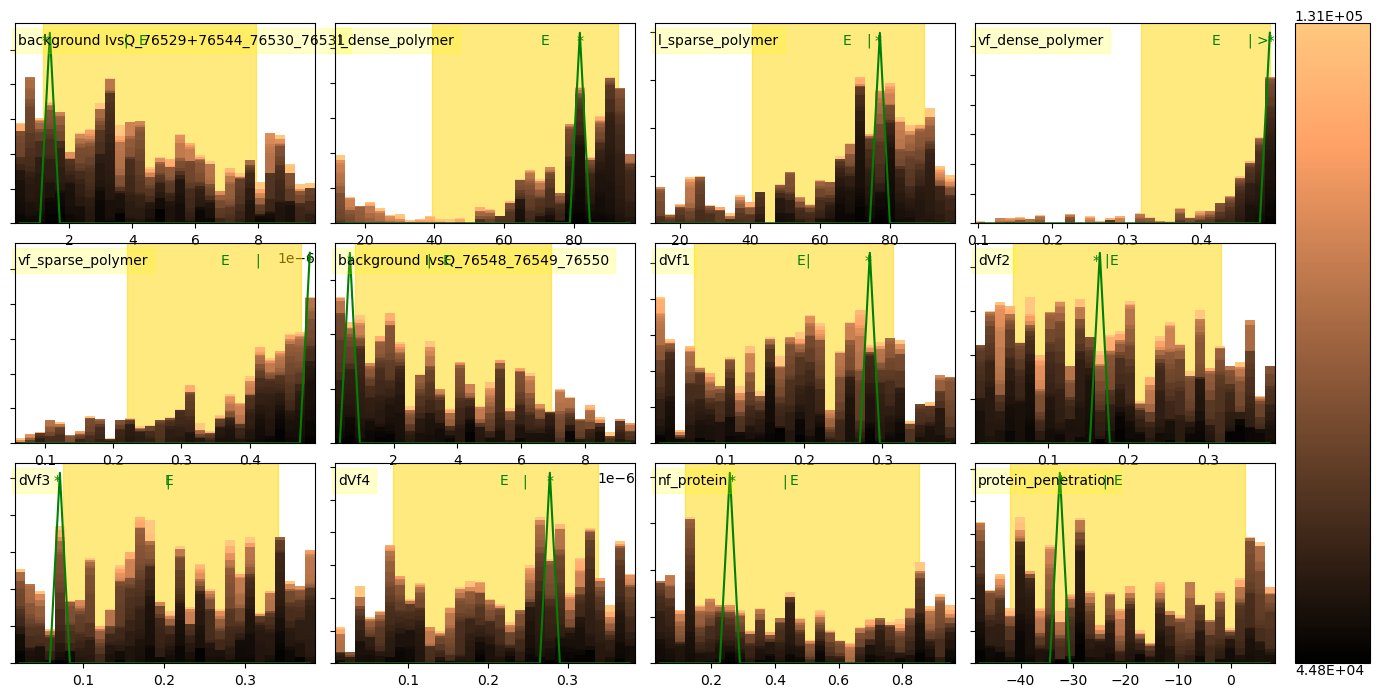

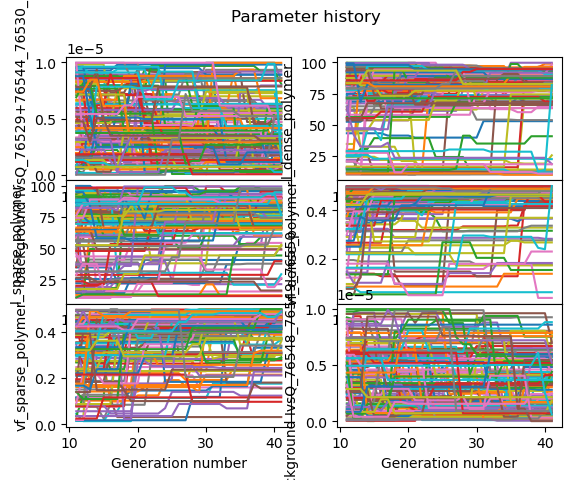

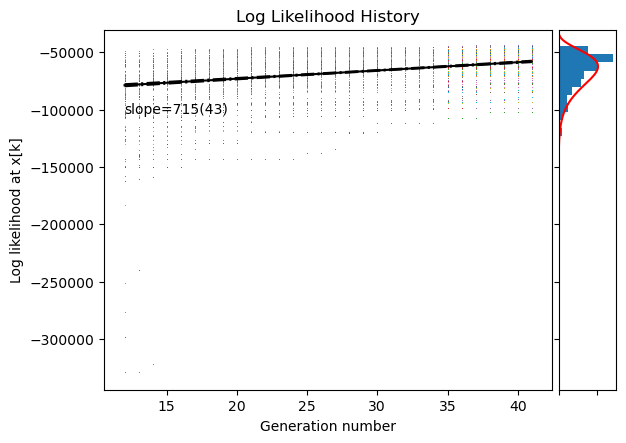

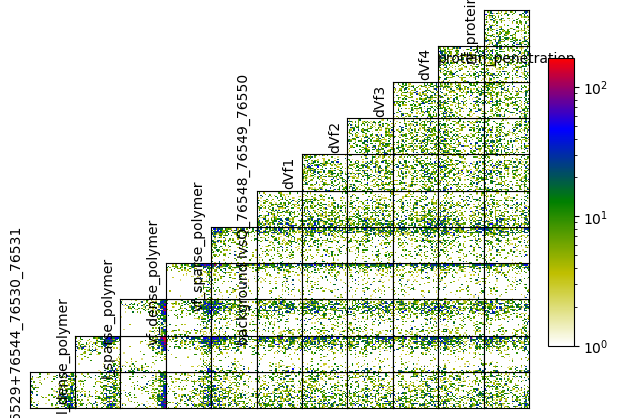

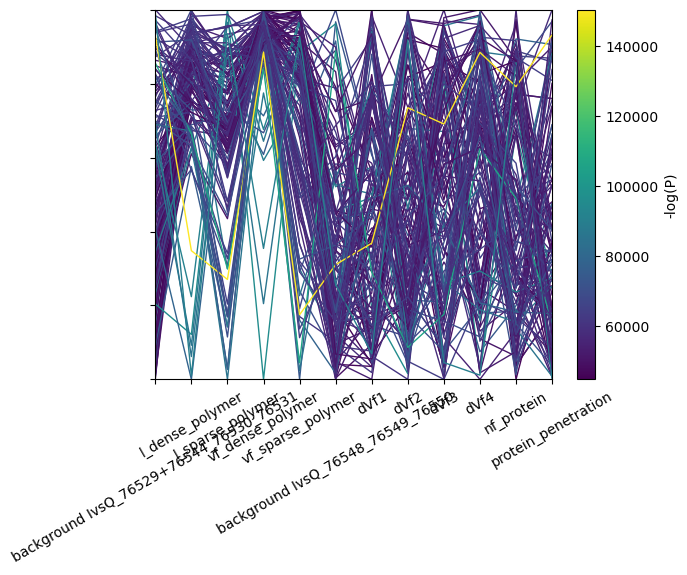

In [4]:
if run:
    if os.path.isdir(store):
        shutil.rmtree(store)
    os.mkdir(store)

fit_object = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None
)

if run:
    # run fit
    fit_object.fnRunFit(burn=burn, steps=steps, batch=False)

print('Restore fit from: ', os.path.join(os.getcwd(), store, runfile))
fit_object.fnRestoreFit()

# Analysis

Statistical analysis of fit results.

Median values, 68% confidence limits (-1, 94%: -2, etc.), and fit intervals for all fit parameters.

In [5]:
sparse = 0.01
fitpars = fit_object.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)
fitpars = fitpars.assign(interval_center = 0.5 * (fitpars['upper percentile'] + fitpars['lower percentile']))
fitpars = fitpars.assign(symmetric_uncertainty = 0.5 * (fitpars['upper percentile'] - fitpars['lower percentile']))
fitpars.to_csv('fitpars.dat', index=False)
fitpars

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of MCMC fit ...
Number of iterations: 34

Fit Parameters:


,origin,name,vis,lower limit,upper limit,lower percentile,median percentile,upper percentile,interval lower,interval upper,confidence,interval_center,symmetric_uncertainty
0,fit,background_IvsQ_76529+76544_76530_76531,[ | - | ],0.00,0.00001,0.000001,0.000003,0.000008,-0.000002,0.000004,0.682689,0.000004,0.000003
1,fit,l_dense_polymer,[ | - |],10.00,100.00000,63.831390,84.425484,95.664734,-20.594094,11.239250,0.682689,79.748062,15.916672
2,fit,l_sparse_polymer,[ | -| ],10.00,100.00000,51.629969,78.729843,90.375260,-27.099874,11.645418,0.682689,71.002615,19.372646
3,fit,vf_dense_polymer,[ | -|],0.02,0.50000,0.342309,0.461123,0.489737,-0.118814,0.028614,0.682689,0.416023,0.073714
4,fit,vf_sparse_polymer,[ | - |],0.01,0.50000,0.255989,0.423046,0.481784,-0.167058,0.058738,0.682689,0.368886,0.112898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,protein,INT,,NaN,NaN,64.852218,170.201780,403.479486,-105.349563,233.277706,0.682689,234.165852,169.313634
157,dense_polymer,COM,,NaN,NaN,30.000000,30.000000,30.000000,0.000000,0.000000,0.682689,30.000000,0.000000
158,dense_polymer,INT,,NaN,NaN,3565.585146,4715.959525,5343.777650,-1150.374379,627.818125,0.682689,4454.681398,889.096252
159,sparse_polymer,COM,,NaN,NaN,61.915695,72.212742,77.832367,-10.297047,5.619625,0.682689,69.874031,7.958336


Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat.

In [6]:
fit_object.fnProfilesStat()

Plot selected data from bilayerplotdata.dat

In [7]:
pandas.DataFrame(fit_object.diStatResults['Molgroups'].keys(), columns=['molecular groups'])

,molecular groups
0,bilayer.defect_hg
1,bilayer.defect_hc
2,bilayer.headgroup1_1
3,bilayer.headgroup1_1.carbonyl_glycerol
4,bilayer.headgroup1_1.choline
...,...
69,bilayer.substrate
70,bilayer.normarea
71,protein
72,dense_polymer


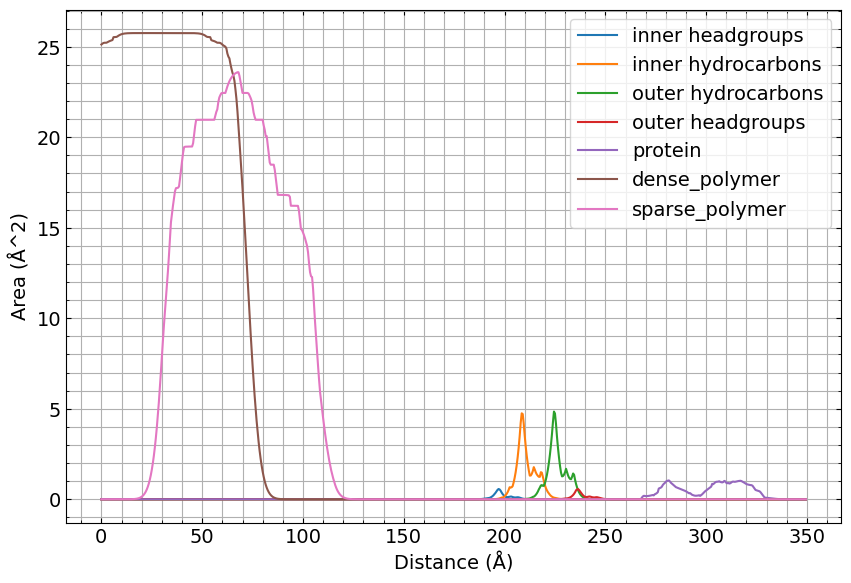

In [13]:
import matplotlib.pyplot as plt

median=['protein',
        'dense_polymer',
        'sparse_polymer']
uncertainties=['KRas']

label = [
    'protein',
    'dense_polymer',
    'sparse_polymer'
]

fig, ax = plt.subplots()
# sums

def plot_and_save(grouplist, label=''):
    if grouplist[0] in fit_object.diStatResults['Molgroups']:
        cvo = numpy.zeros_like(fit_object.diStatResults['Molgroups'][grouplist[0]]['zaxis'])
    else:
        cvo = numpy.zeros_like(fit_object.diStatResults['Molgroups'][grouplist[0]+'_1']['zaxis'])
        
    for group in grouplist:
        if group in fit_object.diStatResults['Molgroups']:
            cvo += fit_object.diStatResults['Molgroups'][group]['median area']
        else:
            i = 1
            while group+ '_' + str(i) in fit_object.diStatResults['Molgroups']:
                cvo += fit_object.diStatResults['Molgroups'][group + '_' + str(i)]['median area']
                i += 1
                
    zaxis = fit_object.diStatResults['Molgroups']['bilayer.headgroup1_1']['zaxis']
    ax.plot(zaxis, cvo, label=label)
    gp = label.replace(" ", "_")
    numpy.savetxt(label+'.dat', numpy.transpose([zaxis, cvo]), delimiter=' ', header=gp+'_zaxis '+gp+'_area ')


plot_and_save(['bilayer.headgroup1'], 'inner headgroups')
plot_and_save(['bilayer.methylene1', 'bilayer.methyl1', 'bilayer.tether_methylene', 'bilayer.tether_methyl'], 'inner hydrocarbons')
plot_and_save(['bilayer.methylene2', 'bilayer.methyl2'], 'outer hydrocarbons')
plot_and_save(['bilayer.headgroup2'], 'outer headgroups')


for i, gp in enumerate(median):
    zaxis = fit_object.diStatResults['Molgroups'][gp]['zaxis']
    area = fit_object.diStatResults['Molgroups'][gp]['median area']
    ax.plot(zaxis, area, label=label[i])
    if gp in uncertainties:
        msigma = fit_object.diStatResults['Molgroups'][gp]['msigma area']
        psigma = fit_object.diStatResults['Molgroups'][gp]['psigma area']
        ax.fill_between(zaxis, msigma, psigma, alpha=0.3)
        numpy.savetxt(label[i]+'.dat', numpy.transpose([zaxis, area, msigma, psigma]), delimiter=' ', header=gp+'_zaxis '+gp+'_area '+gp+'_msigma_area '+gp+'_psigma_area')

ax.legend(loc="upper right", fontsize=14)
plt.xlabel("Distance (Å)", fontsize=14)
plt.ylabel("Area (Å^2)", fontsize=14)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=14)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 130)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

Compute statistical properties of interest with 68% confidence limits, such as the area per lipid of the outer lipid
leaflet.

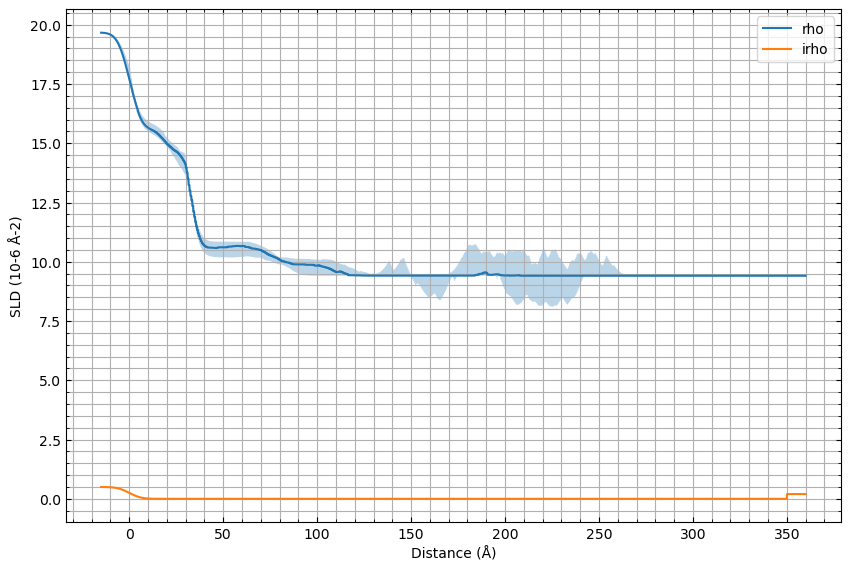

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
zaxis = fit_object.diStatResults['SLD']['z']

median = fit_object.diStatResults['SLD']['median rho']
ax.plot(zaxis, median, label='rho')
msigma = fit_object.diStatResults['SLD']['msigma rho']
psigma = fit_object.diStatResults['SLD']['psigma rho']
ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

median = fit_object.diStatResults['SLD']['median irho']
ax.plot(zaxis, median, label='irho')
msigma = fit_object.diStatResults['SLD']['msigma irho']
psigma = fit_object.diStatResults['SLD']['psigma irho']
ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("SLD (10-6 Å-2)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/sld", facecolor="white")
plt.show()

A simple way to show output files from the fit. Publication-ready graphs can be created from the data in the storage
directory or using fit_object:

# Publication-ready graphs

...

# Useful Routines


In [ ]:
model = load_model(runfile+'.py')
load_best(model, os.path.join(store, runfile)+'.par')
model.chisq_str()

In [ ]:
from IPython.display import Image, display
import glob
for file in glob.glob(os.path.join(store, "*.png")):
    display(Image(filename=file))